Starting code for a MLP classifier for cardiac arrest for tabular data - Josh

In [428]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics   



In [380]:
df = pd.read_csv("1000_nonca_574_ca.csv")
# df = pd.read_csv("added_feature_1000_nca_574_ca.csv")

In [381]:
df.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,cardiac,ADMITTIME,DISCHTIME,DOB,age
0,9633,79229,145474,67.0,21.0,96.0,NaN,NaN,M,0,2153/2/11 22:20,2153/2/14 18:00,2074/6/3 0:00,78
1,498,32511,102385,70.0,20.0,96.0,NaN,NaN,M,0,2147/9/22 6:12,2147/10/2 16:30,2060/10/23 0:00,86
2,11180,51767,152759,83.0,15.5,99.0,NaN,NaN,M,0,2191/6/16 11:45,2191/6/21 14:30,2132/7/18 0:00,58
3,8170,46755,138568,78.0,15.0,96.0,NaN,NaN,F,0,2183/3/8 10:24,2183/3/13 15:13,2122/10/27 0:00,60
4,13220,85417,162413,64.0,20.0,96.0,NaN,NaN,M,0,2183/9/8 0:19,2183/10/3 16:50,2131/11/1 0:00,51


In [382]:
df.drop(['ADMITTIME', 'DISCHTIME', 'DOB'], axis=1, inplace=True)
df.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,cardiac,age
0,9633,79229,145474,67.0,21.0,96.0,NaN,NaN,M,0,78
1,498,32511,102385,70.0,20.0,96.0,NaN,NaN,M,0,86
2,11180,51767,152759,83.0,15.5,99.0,NaN,NaN,M,0,58
3,8170,46755,138568,78.0,15.0,96.0,NaN,NaN,F,0,60
4,13220,85417,162413,64.0,20.0,96.0,NaN,NaN,M,0,51


In [383]:
# df = df[['SUBJECT_ID', 'HADM_ID', '220045', '220210', '220277', '224167', '227243','223770','223769','226253','220046','220047', 'gender','age','cardiac']]
df = df[['SUBJECT_ID', 'HADM_ID', '220045', '220210', '220277', '224167', '227243', 'gender','age','cardiac']]
df.head()

,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,age,cardiac
0,79229,145474,67.0,21.0,96.0,NaN,NaN,M,78,0
1,32511,102385,70.0,20.0,96.0,NaN,NaN,M,86,0
2,51767,152759,83.0,15.5,99.0,NaN,NaN,M,58,0
3,46755,138568,78.0,15.0,96.0,NaN,NaN,F,60,0
4,85417,162413,64.0,20.0,96.0,NaN,NaN,M,51,0


In [384]:
# pd.get_dummies(df['gender'])
cleanup_nums = {"gender":     {"F": 0, "M": 1}}
df.replace(cleanup_nums, inplace=True)
df.head()

,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,age,cardiac
0,79229,145474,67.0,21.0,96.0,NaN,NaN,1,78,0
1,32511,102385,70.0,20.0,96.0,NaN,NaN,1,86,0
2,51767,152759,83.0,15.5,99.0,NaN,NaN,1,58,0
3,46755,138568,78.0,15.0,96.0,NaN,NaN,0,60,0
4,85417,162413,64.0,20.0,96.0,NaN,NaN,1,51,0


In [385]:
df.drop(['SUBJECT_ID','HADM_ID','224167','227243'], axis=1, inplace=True)
df.head(2)

,220045,220210,220277,gender,age,cardiac
0,67.0,21.0,96.0,1,78,0
1,70.0,20.0,96.0,1,86,0


In [386]:
df=df.fillna(df.mean())


In [387]:
# TESTINGTESTINGTESTINGTESTINGTESTINGTESTINGTESTINGTESTING
# df.drop(['223770','223769','226253','220046','220047'], axis=1, inplace=True)
# df.head(2)

Look for a potential class imbalance here

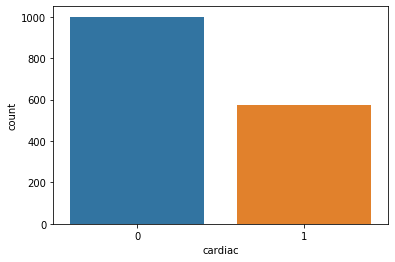

In [388]:
sns.countplot(x = 'cardiac', data=df)

In [389]:
# Class count
count_class_0, count_class_1 = df.cardiac.value_counts()
# Divide by class
df_class_0 = df[df['cardiac'] == 0]
df_class_1 = df[df['cardiac'] == 1]

Random under-sampling:
1    574
0    574
Name: cardiac, dtype: int64


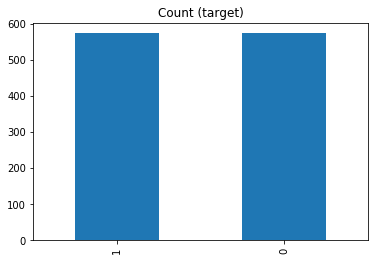

In [390]:
# Random under-sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.cardiac.value_counts())

df_test_under.cardiac.value_counts().plot(kind='bar', title='Count (target)');

In [391]:
df_test_under.head()

,220045,220210,220277,gender,age,cardiac
451,110.0,31.0,96.0,1,67,0
356,69.0,26.0,94.0,0,70,0
789,85.5,16.0,96.0,0,58,0
20,95.0,16.0,99.0,0,40,0
323,84.5,23.0,94.0,1,69,0


In [392]:
df.head()

,220045,220210,220277,gender,age,cardiac
0,67.0,21.0,96.0,1,78,0
1,70.0,20.0,96.0,1,86,0
2,83.0,15.5,99.0,1,58,0
3,78.0,15.0,96.0,0,60,0
4,64.0,20.0,96.0,1,51,0


In [393]:
df_test_under.to_csv('balanced_dataset.csv')

In [394]:
df_test_under=df_test_under.sort_index()

In [395]:
df=df_test_under

Encode Output Class (remaps the labels to start from 0) (not sure if needed)

In [396]:
# df['Cardiac_arrest'] = df['Cardiac_arrest'].astype('category')
# encode_map = {
#     'Abnormal': 1,
#     'Normal': 0
# }

# df['Cardiac_arrest'].replace(encode_map, inplace=True)

Create Input and Output Data

In [397]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [398]:
X.head(2)

,220045,220210,220277,gender,age
0,67.0,21.0,96.0,1,78
1,70.0,20.0,96.0,1,86


In [399]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1569    1
1570    1
1571    1
1572    1
1573    1
Name: cardiac, Length: 1148, dtype: int64

In [400]:
X=X.fillna(X.mean())
y=y.fillna(y.mean())

In [401]:
X

,220045,220210,220277,gender,age
0,67.0,21.0,96.0,1,78
1,70.0,20.0,96.0,1,86
2,83.0,15.5,99.0,1,58
3,78.0,15.0,96.0,0,60
4,64.0,20.0,96.0,1,51
...,...,...,...,...,...
1569,82.0,21.0,98.0,0,46
1570,65.5,17.0,94.0,1,86
1571,76.0,21.0,98.0,1,69
1572,65.0,18.0,97.0,0,59


In [402]:
# from sklearn import preprocessing

# x = X.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# X2 = pd.DataFrame(x_scaled)

In [403]:
# # DOING PCA
# import pandas as pd
# import numpy as np
# from sklearn.decomposition import PCA

# # df134124 = pd.DataFrame(data=np.random.normal(0, 1, (20, 10)))

# num_components=5

# pca = PCA(n_components=num_components)
# pca.fit(X)
# pca.components_ 
# X2=pd.DataFrame(pca.transform(X), columns=['PCA%i' % i for i in range(num_components)], index=df.index)


In [404]:
# print(pca.explained_variance_)


In [405]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=10)

In [406]:
X_train.head(5)

,220045,220210,220277,gender,age
1350,72.0,33.5,96.0,1,82
1045,69.0,21.0,100.0,0,52
384,101.0,24.0,97.0,1,47
890,91.5,20.0,97.0,1,55
1161,63.0,17.0,100.0,1,72


In [407]:
y_train.head(5)

1350    1
1045    1
384     0
890     0
1161    1
Name: cardiac, dtype: int64

In [408]:
X_train.shape

(975, 5)

In [409]:
X_test.shape

(173, 5)

In [410]:
y_test.shape

(173,)

In [411]:
y_train.shape

(975,)

Standardize Input Values

In [412]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Model HyperParameters

In [413]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

Define a Dataloader

In [414]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train.values))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

Initialize a dataloader with a batch_size = 1 for our test dataloader.

In [415]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

The input to our first nn.Linear layer would be 16 Since the number of input features in our dataset is 16

In [416]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 5.
        self.layer_1 = nn.Linear(5, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

Check for GPU

In [417]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Initialize optimizer and loss function

In [418]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=5, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [419]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

Train the model

In [420]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         print('X_batch: ',X_batch.shape)
        if (X_batch.shape != torch.Size([64, 5])):
            continue
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

#     print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Test the model

In [421]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [422]:
len(y_pred_list)
# y_test

173

In [423]:
# Calculate the confusion matrix
cf=confusion_matrix(y_test, y_pred_list)

In [430]:
tn = cf[0][0]
fp = cf[0][1]
fn = cf[1][0]
tp = cf[1][1]
sensitivity= tp/(tp+fn)
specificity = tn /(tn+fp)
print('sensitivity: ',sensitivity)
print('specificity: ',specificity)
print('ROC AUC: ',metrics.roc_auc_score(y_test, y_pred_list))

sensitivity:  0.5888888888888889
specificity:  0.5903614457831325
ROC AUC:  0.5896251673360108


In [425]:
# Print classification report with precision, recall, and F1 score
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.57      0.59      0.58        83
           1       0.61      0.59      0.60        90

    accuracy                           0.59       173
   macro avg       0.59      0.59      0.59       173
weighted avg       0.59      0.59      0.59       173

